In [1]:
import pandas as pd
import numpy as np
import time
from tqdm import trange
import multiprocessing as mlp
import os
import sys
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from tqdm import trange

In [3]:
plt.rcParams['figure.figsize'] = (20,10)

# Data Understanding and Data Pre-Proccessing

In [4]:
data = pd.read_csv('EUR_USD_M30_Output_Since_2005.csv')

In [5]:
data.head(5)

,DateTime,Volume,Open,High,Low,Close
0,2005-01-02T18:00:00.000000000Z,1,1.3560,1.3560,1.3560,1.3560
1,2005-01-02T18:30:00.000000000Z,5,1.3560,1.3568,1.3560,1.3567
2,2005-01-02T19:00:00.000000000Z,32,1.3569,1.3570,1.3556,1.3556
3,2005-01-02T19:30:00.000000000Z,12,1.3556,1.3565,1.3556,1.3558
4,2005-01-02T20:00:00.000000000Z,27,1.3559,1.3561,1.3556,1.3558


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166972 entries, 0 to 166971
Data columns (total 6 columns):
DateTime    166972 non-null object
Volume      166972 non-null int64
Open        166972 non-null float64
High        166972 non-null float64
Low         166972 non-null float64
Close       166972 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 7.6+ MB


In [7]:
data.isnull().sum() 

DateTime    0
Volume      0
Open        0
High        0
Low         0
Close       0
dtype: int64

In [8]:
data.isna().sum()

DateTime    0
Volume      0
Open        0
High        0
Low         0
Close       0
dtype: int64

In [9]:
data = data.iloc[:,[0,2,5]]

In [10]:
data.DateTime = pd.to_datetime(data.DateTime)

In [11]:
data.head(5)

,DateTime,Open,Close
0,2005-01-02 18:00:00,1.3560,1.3560
1,2005-01-02 18:30:00,1.3560,1.3567
2,2005-01-02 19:00:00,1.3569,1.3556
3,2005-01-02 19:30:00,1.3556,1.3558
4,2005-01-02 20:00:00,1.3559,1.3558


In [12]:
# data['diff'] = (data.iloc[:,2] - data.iloc[:,1])

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


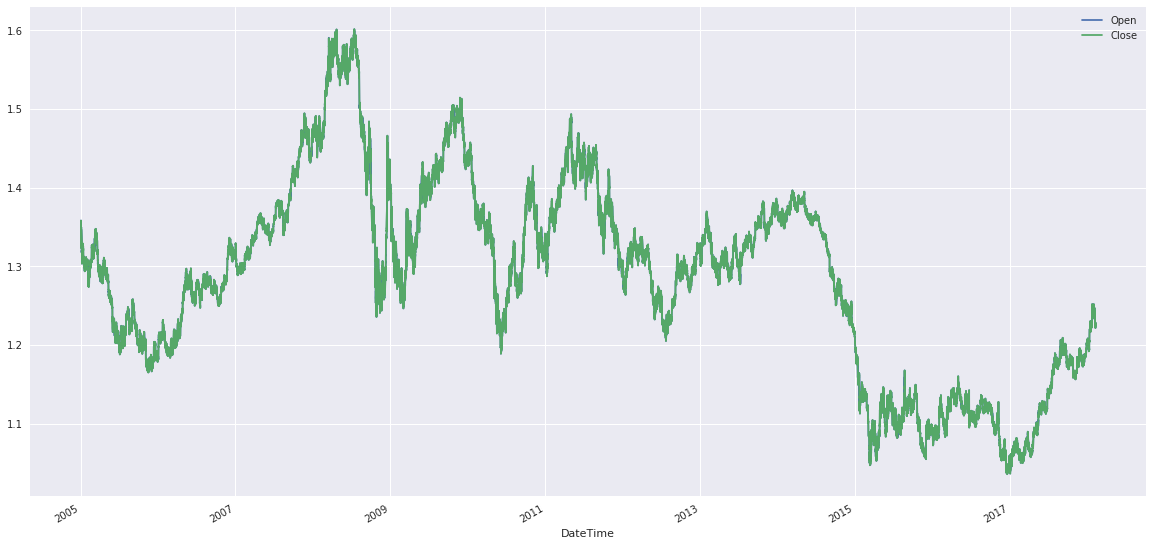

In [13]:
# plt.plot(range(len(data)) , data.iloc[: , 1])
data.plot(x='DateTime', y=['Open', 'Close'])

open and close price seem to be so close , so we would need one of them.

In [14]:
data = data.iloc[:, [0,2]]
data = data.rename(columns={'Close': 'Value'})

# Hyper Parameters

In [15]:
P = 12             # how many points to use for calulations
F = 10             # gap between last point and start range of measuring outcome of pattern
H = 70             # how similar recognized patters should be
Max_sim = 250      # maximum number of allowed selected similar pattern
Min_sim = 20       # minimum number of allowed selected similar pattern

# calculate diffrence in default length 

*** this difference is kind of normalized in the whole project and it's gonna be used anywhere difference measurement needed***

In [16]:
def percent_change(start_p, current_p):
    try:
        x = ((current_p - start_p) / abs(start_p)) * 100
        if x == 0:
            return 1e-10
        else:
            return x
    except Exception as e:
        return 1e-10

In [17]:
percent_change(data.iloc[0,1] , data.iloc[1,1])

0.05162241887905036

# Pattern Recognizer

In [18]:
x = len(data) - (P+F)
y = P + 1
pattern_ar = []
performance_ar =[]

for y in trange(P+1, x):
    tmp_pattern = []
    for i in range(P-1, -1, -1):
        tmp_pattern.append(percent_change(data.Value[y-P], data.Value[y-i]))

    current_point = data.Value[y]
    outcome_range = data.Value[y+F : y+P+F]
    try:
        avrage_outcome = outcome_range.mean()
    except Exception as e:
        print(e)
        avrage_outcome = 1e-10
        
    future_outcome = percent_change(current_point, avrage_outcome)
    
    pattern_ar.append(tmp_pattern)
    performance_ar.append(future_outcome)
    
    
#     print('current :', current_point)
#     print('outcome :', avrage_outcome)
#     print('percent change outcome :', future_outcome, '%')
#     print('_______')
#     print(tmp_pattern)
#     break

pattern_ar = np.array(pattern_ar)
performance_ar = np.array(performance_ar)

100%|██████████| 166937/166937 [01:55<00:00, 1442.75it/s]


In [19]:
t = 35566
print(performance_ar[t])
print(pattern_ar[t])

0.06596461469593515
[-0.00705985 -0.11295765 -0.06212671 -0.15531678 -0.13272524 -0.19485195
 -0.22732728 -0.21885546 -0.24003502 -0.18073225 -0.12284145 -0.11013371]


In [20]:
len(performance_ar[performance_ar > 0])

83525

# Pattern Finder

In [21]:
def pattern_finder(d):
    pt = []
    d = list(d)
    for i in range(1, len(d)):
        pt.append(percent_change(d[0], d[i]))
    return np.array(pt)

# Similarity Checker

In [22]:
def sim_check(pat, h, verbos=True):
    if verbos == True:
        sim_pat_inx = []
        for p in trange(len(pattern_ar)):
            sim = []
            for i in range(P):
                sim.append(100 - abs(percent_change(pat[i], pattern_ar[p][i])))
            sim = np.array(sim)
            # max of how sim = 100
            how_sim = sim.mean()

        #     print(sim)
        #     print(how_sim)

            if how_sim >= h:
                sim_pat_inx.append([p, how_sim])
        print(len(sim_pat_inx), 'similar pattern found!')
    #     print(sim_pat_inx)
    else:
        sim_pat_inx = []
        for p in range(len(pattern_ar)):
            sim = []
            for i in range(P):
                sim.append(100 - abs(percent_change(pat[i], pattern_ar[p][i])))
            sim = np.array(sim)
            # max of how sim = 100
            how_sim = sim.mean()

        #     print(sim)
        #     print(how_sim)

            if how_sim >= h:
                sim_pat_inx.append([p, how_sim])
        print(len(sim_pat_inx), 'similar pattern found!')
    #     print(sim_pat_inx)        
    
    return sim_pat_inx

*** Ploting last pattern and similar patterns to that ***

In [23]:
def plot_pat_sim(pat=None, sim_ar=None, h=None, plot_current=True):
    if h is None:
        h = H
    # in case nothing passed to func default mode would be ploting last pattern (h is not necessary)
    if plot_current == True and pat is None and sim_ar is None:
        pat = pattern_finder(data.Value.iloc[y+F: y+P+1+F])
        sim_ar = sim_check(pat, h)
    # in case just a pattern passed to func, automaticaly similiar patterns array will be created and ploted
    elif pat is not None and sim_ar is None:
        sim_ar = sim_check(pat, h)
        plot_current = False
    # in case pattern and similar array passed to func
    elif pat is not None and sim_ar is not None:
        plot_current = False
        print(len(sim_ar), 'similar pattern found!')
    else:
        print('Input Error!!!')
    
    
    for i in range(len(sim_ar)):
        plt.plot(range(1,P+1), pattern_ar[sim_ar[i][0]], linewidth=1)

        tmp_performance = performance_ar[sim_ar[i][0]]
        # if statement is because if future performance is upper than current patterns' change line
        if tmp_performance > pat[-1]:
            pcolor = 'green'
        else:
            pcolor = 'red'
        plt.scatter(P+.5, performance_ar[sim_ar[i][0]], c=pcolor, alpha=0.5)

    predict_value = sum([performance_ar[s[0]] for s in sim_ar]) / len(sim_ar)
    plt.scatter(P+1 , predict_value, c='red')
    plt.plot(range(1,P+1), pat, c='red', linewidth=3)
    plt.show()

100%|██████████| 166937/166937 [00:05<00:00, 31004.29it/s]


82 similar pattern found!


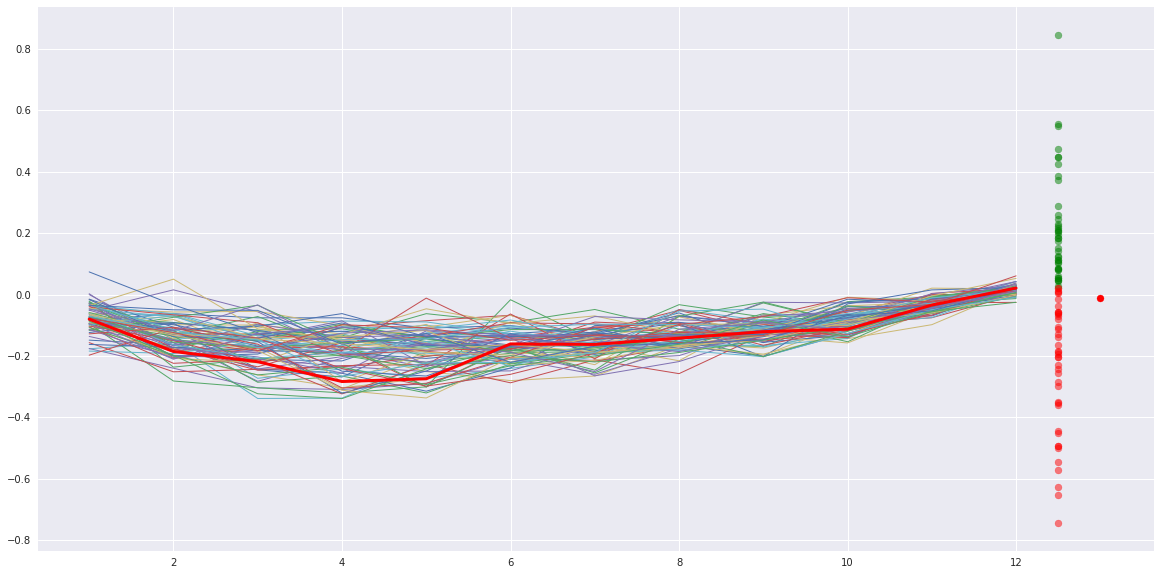

In [24]:
plot_pat_sim(h=60)

# Predictor

In [25]:
predicted_values_ar = []
tmp_pat = []
tmp_sim_pat_inx = []
pred_data_frame = pd.DataFrame(columns=['DateTime', 'Value'])


def predictor(t):
    global predicted_values_ar, tmp_pat, tmp_sim_pat_inx, pred_data_frame
    
    try:
        pred_data_frame = pd.read_csv('pred_data.csv')
    except:
        pass
        
    try:
        tmp_sim_pat_inx = np.load('sim_pat_data.npy').tolist()
    except:
        tmp_sim_pat_inx = []
    
    try:
        tmp_pat = np.load('pat_data.npy').tolist()
    except:
        tmp_pat = []
    
    tmp_data = list(data.Value) + list(pred_data_frame.Value)
    last_used_point = y + len(pred_data_frame)
    predicted_values_ar = list(pred_data_frame.Value)
    
    T = pd.to_datetime(t)
    t_delta = T - data.DateTime[last_used_point]
    m = int(((t_delta.total_seconds() / 3600) * 2) - P - F)
    
    try:
        t_p = tmp_data[last_used_point + m + P + F]
        return t_p
    except:
        pass
    
    print('total points to procces:', m)
    
    h = H
    for i in trange(1, m+1):
        tmp_pat.append(pattern_finder(tmp_data[last_used_point+i : last_used_point+i+P+1]))
        print('point number', i, ':')
        
        tmp_sim_pat_inx.append(sim_check(tmp_pat[-1], h, verbos=False))
        while len(tmp_sim_pat_inx[-1]) > Max_sim or len(tmp_sim_pat_inx[-1]) < Min_sim:
            while len(tmp_sim_pat_inx[-1]) < Min_sim:
                h -= 3
                print('how sim changed to',h)
                tmp_sim_pat_inx.pop(-1)
                tmp_sim_pat_inx.append(sim_check(tmp_pat[-1], h, verbos=False))
            while len(tmp_sim_pat_inx[-1]) > Max_sim:
                h += 3
                print('how sim changed to',h)
                tmp_sim_pat_inx.pop(-1)
                tmp_sim_pat_inx.append(sim_check(tmp_pat[-1], h, verbos=False))
                
        pred_change = sum([performance_ar[s[0]] for s in tmp_sim_pat_inx[-1]]) / len(tmp_sim_pat_inx[-1])
        predicted_values_ar.append(pred_change + tmp_data[last_used_point+i])
        tmp_data.append(predicted_values_ar[-1])
        

    # saving part
    pred_data_frame = pd.DataFrame(columns=['DateTime', 'Value'])
    for i in range(len(predicted_values_ar)):
        t = data.DateTime.iloc[-1] + pd.Timedelta('{}min'.format(30*(i+1)))
        v = predicted_values_ar[i]
        pred_data_frame.loc[i] = [t, v]
    
    pred_data_frame.to_csv('pred_data.csv', index=False)
    np.save('sim_pat_data', tmp_sim_pat_inx)
    np.save('pat_data', tmp_pat)

    return predicted_values_ar[-1]

# predictor('2018-02-10 00:30:00')
    

In [35]:
predictor('2018-02-10 01:00:00')

1.235774579461668

In [27]:
# predictor('2018-02-10 8:30:00')

# predictor('2018-02-16 01:30:00')
# 1.2539

# predictor('2018-03-20 8:30:00')
# 1.2266

25 similar pattern found!


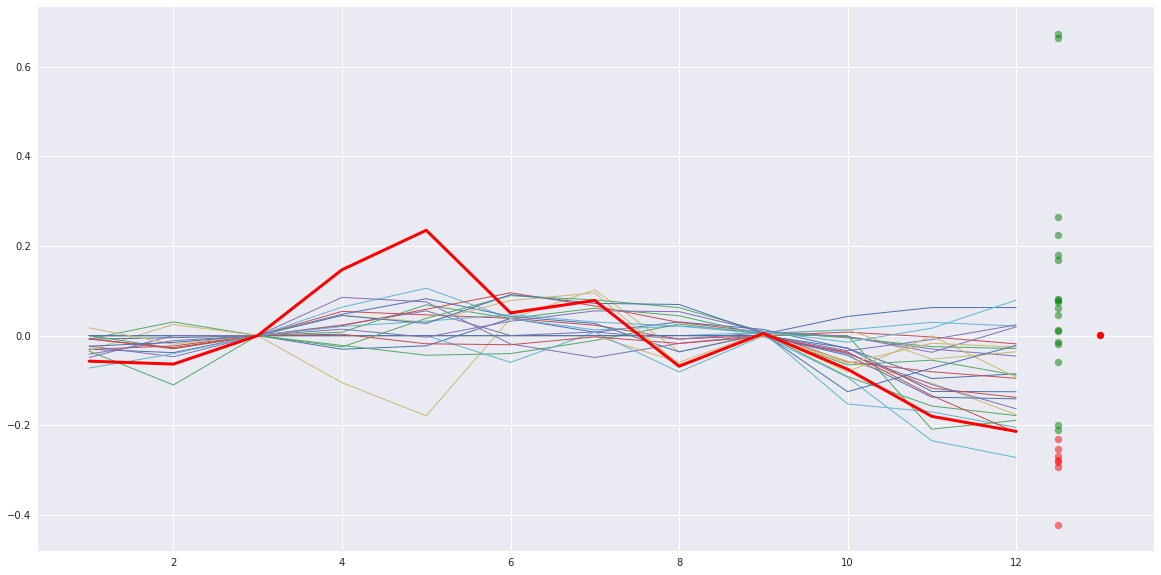

In [32]:
plot_pat_sim(pat=tmp_pat[0], sim_ar=tmp_sim_pat_inx[0])

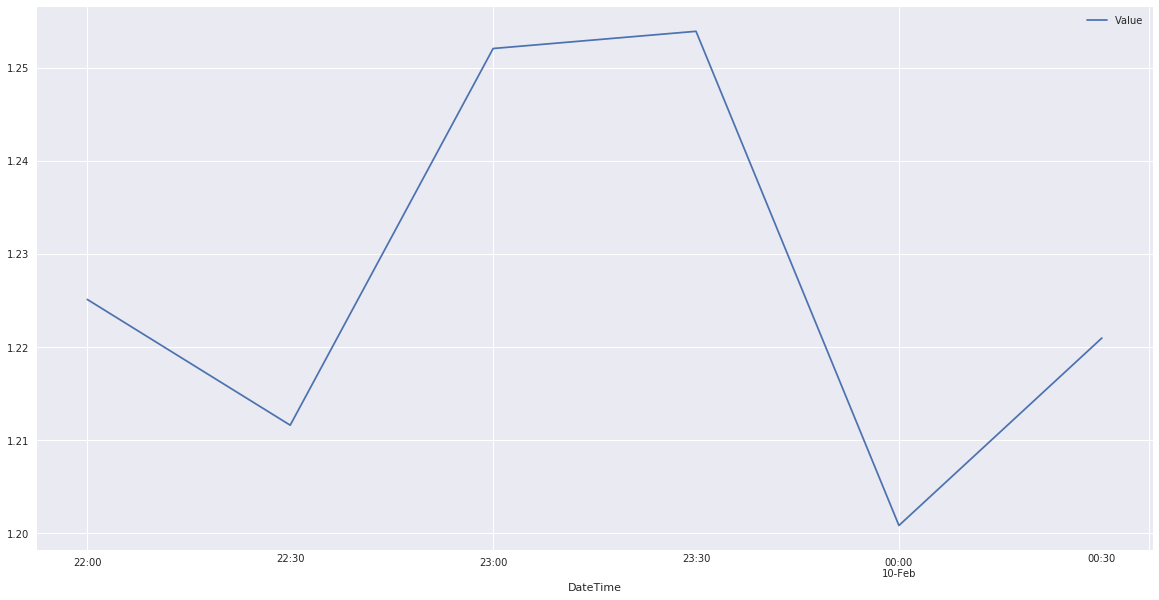

In [30]:
pred_data_frame.plot(x='DateTime', y='Value')

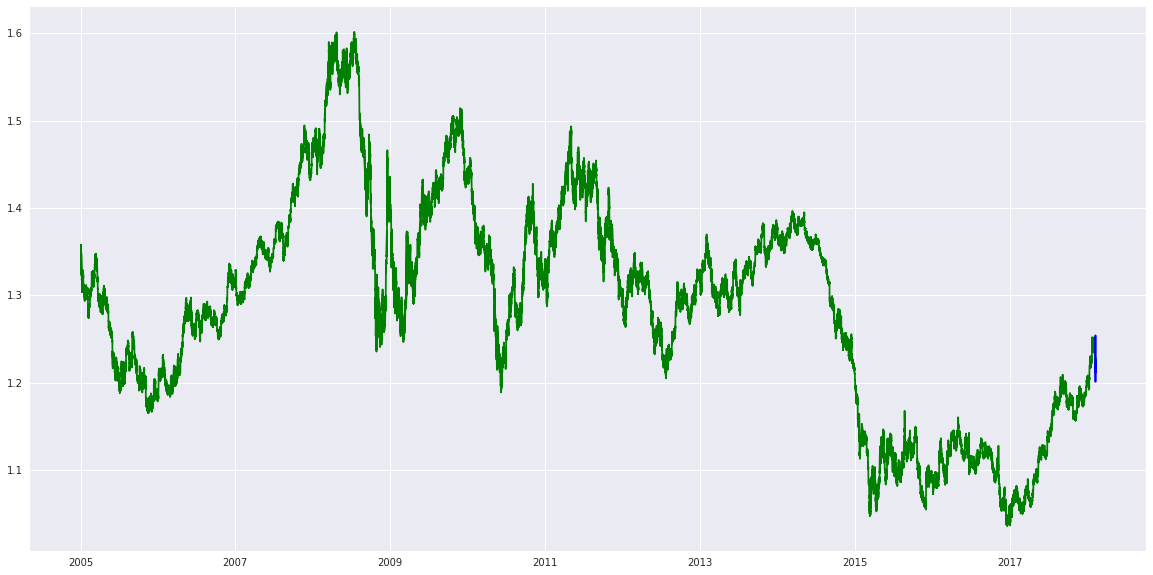

In [31]:
plt.plot(data.DateTime, data.Value, c='green')
plt.plot(pred_data_frame.DateTime, pred_data_frame.Value, c='blue')